In [1]:
import numpy as np
import seaborn as sns

from felpy.utils.np_utils import get_mesh
from felpy.utils.vis_utils import basic_plot, simple_line_plot, colorbar_plot, signal_plot, scatter_plot
from wpg.beamline import Beamline
from wpg.optical_elements import Aperture, Drift
from felpy.model.core.wavefront import Wavefront

from matplotlib import pyplot as plt

from numpy import fft 
from felpy.utils.opt_utils import ekev2wav


In [2]:
def gaussian_envelope(x, x0, width):
    """ 
    generate a gaussian envelope for modelling the integrated pulse_data
    
    :param x: 1D list of time/frequency positions
    :param x0: central time/frequency
    :param width: width of XFEL pulse
    """
    return np.exp(-np.power(x - x0, 2.) / (2 * np.power(width, 2.)))


In [3]:
def temporal_sampling_requirements(pulse_time, VERBOSE = True):
    """ 
    calculate the number of samples required for the defined pulse length.
    
    from Partial-coherence method to model experimental free-electron laser pulse statistics - Pfeifer - 2021 -
    Optics Letters - Vol. 35 No 20.
    
    We expect the number of sampling intervals to satisfy
    |w_{i} - w_{i+1} << 2\pi/tau
    where tau is pulse time.

    :params pulse_time: length of the XFEL pulse
    :returns n: number of sampling intervals req.
    
    NOTE: a<<b is set to satisfy a*10<b
    """
    freq_sampling = (2*np.pi)/(pulse_time)
    temporal_sampling = 1/(freq_sampling*10)
    n = int(pulse_time//temporal_sampling + 1)
    
    if VERBOSE:
        print("Frequency Sampling Interval: {:.2e} Hz".format(freq_sampling))
        print("Temporal Sampling Interval: {:.2e} s".format(temporal_sampling))
        print("Number of Req. Samples: {}".format(n))
    
    return n, temporal_sampling 

In [4]:
n_samples, sampling_interval_t = temporal_sampling_requirements(40e-15, VERBOSE = True)
sampling_interval_w = 1/sampling_interval_t

Frequency Sampling Interval: 1.57e+14 Hz
Temporal Sampling Interval: 6.37e-16 s
Number of Req. Samples: 63


In [5]:
def generate_temporal_SASE_pulse(pulse_time, VERBOSE = True):
    """ 
    generate a single SASE pulse
    
    assumes that the spectral and temporal bandwidth are the pulse are reciprocal, 
    assumes that the spectral and temporal profiles are gaussian,
    assumes that there is no jitter from the central value of the Gaussian (ie, the pulse profile
    is persistent).
    
    in future, we will extend this extned the functionality to account for non-Gaussian profiles,
    and pulse-length jitter.
    
    it will also be useful to trim the function to the relevant regions (and thus reduce the number of points) 
    
    :param pulse_time: expectation value of the SASE pulse time
    :param VERBOSE: [bool] enables printing and plotting
    """
    
    t = np.arange(-pulse_time*4, pulse_time*4, pulse_time/n_samples)
    temporal_envelope = (1/np.sqrt(2*np.pi))*gaussian_envelope(t, 0, pulse_time)

    spectral_bw = 1/pulse_time
    w = 1/t
    spectral_envelope = gaussian_envelope(w, 0, spectral_bw)
    
    random_phases = np.random.uniform(-np.pi, np.pi, temporal_envelope.shape)

    E_t = fft.fft(spectral_envelope*np.exp(1j*random_phases))*temporal_envelope
    
    if VERBOSE:
        signal_plot(t, abs(E_t)**2,
                   xlabel = "Time (s)",
                   ylabel = "Intensity (a.u.)",
                   title = 'SASE Pulse',
                   context = 'talk')
    
    return E_t

In [243]:
pulse_time = 40e-15
t = np.arange(-pulse_time*4, pulse_time*4, pulse_time/n_samples)

temporal_profile = generate_temporal_SASE_pulse(pulse_time = 40e-15, VERBOSE = False)
 

In [244]:
def complex_gaussian(mesh, waist, wz, R, wav):
    k = np.pi * 2 / wav
    x = mesh[0]
    y = mesh[1]
    factor_1 = -(x**2+y**2)/wz**2
    factor_2 = -1j*k*(x**2+y**2)/(2*R)
    
    return np.exp(factor_1)*np.exp(factor_2)

x = -np.linspace(-400, 400, 300)
y = np.linspace(-400, 400, 300)
grid = np.meshgrid(x,y)

spatial_profile = complex_gaussian(mesh = grid, waist = 100, wz = 50, R = 1, wav = ekev2wav(9.2))
#plt.imshow(abs(spatial_profile)**2)
from felpy.model.src.coherent import construct_SA1_wavefront
spatial_profile = construct_SA1_wavefront(300,300,9.2,0.25).as_complex_array()


In [241]:
def complex_to_wpg(arr): ### converter
    new_arr = np.zeros([arr.shape[0], arr.shape[1], arr.shape[2], 2])
    new_arr[:,:,:,0] = arr.real
    new_arr[:,:,:,1] = arr.imag
    return new_arr

In [250]:
from wpg.optical_elements import Drift
from felpy.model.tools import propagation_parameters
from wpg.srwlib import SRWLWfr
from wpg.wpg_uti_wf import plot_total_power 
from scipy.constants import c
print(spatial_profile.shape, temporal_profile.shape)

cfr = spatial_profile[:,:,:]*temporal_profile
print(cfr.shape)
print(np.max(cfr))

def wavefront_from_array(cfr,nx,ny,nz,dx,dy,dz,ekev):
    

    # Initialize empty wavefront.
    wfr = Wavefront()

    # Setup E-field.
    wfr.data.arrEhor = np.zeros(shape=(nx, ny, nz, 2))
    wfr.data.arrEver = np.zeros(shape=(nx, ny, nz, 2))
    
    wfr.params.wEFieldUnit = 'sqrt(W/mm^2)'
    wfr.params.photonEnergy = ekev * 1000
    wfr.params.wDomain = 'time'
    wfr.params.Mesh.nSlices = nz
    wfr.params.Mesh.nx = nx
    wfr.params.Mesh.ny = ny
    

    pulse_length = (nz - 1) * dz / (c)
    
    wfr.params.Mesh.sliceMin = -pulse_length / 2.
    wfr.params.Mesh.sliceMax = pulse_length / 2.

    range_x = dx*nx
    range_y = dy*ny
    
    wfr.params.Mesh.xMin = -range_x / 2.
    wfr.params.Mesh.xMax = range_x / 2.
    wfr.params.Mesh.yMin = -range_y / 2.
    wfr.params.Mesh.yMax = range_y / 2.

    

    wfr.data.arrEhor = cfr
    return wfr

cfr = complex_to_wpg(cfr)


(300, 300, 1) (504,)
(300, 300, 504)
(3457652344.5007157-655458845.3814836j)


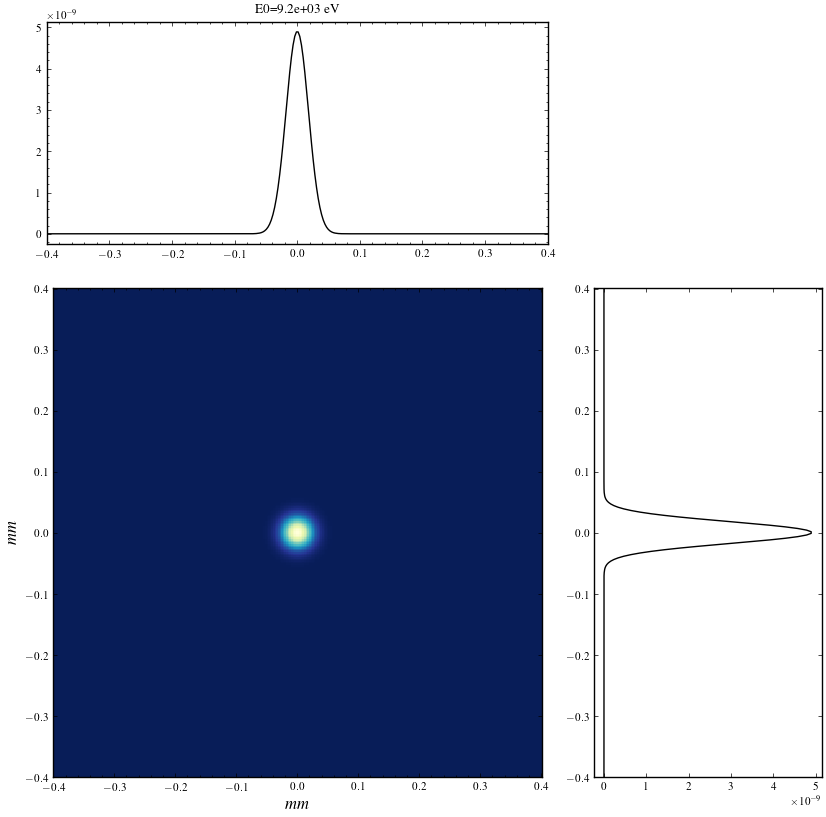

(array([1.19280797e-05, 1.19280797e-05]), 1.4219203342339532e-06)


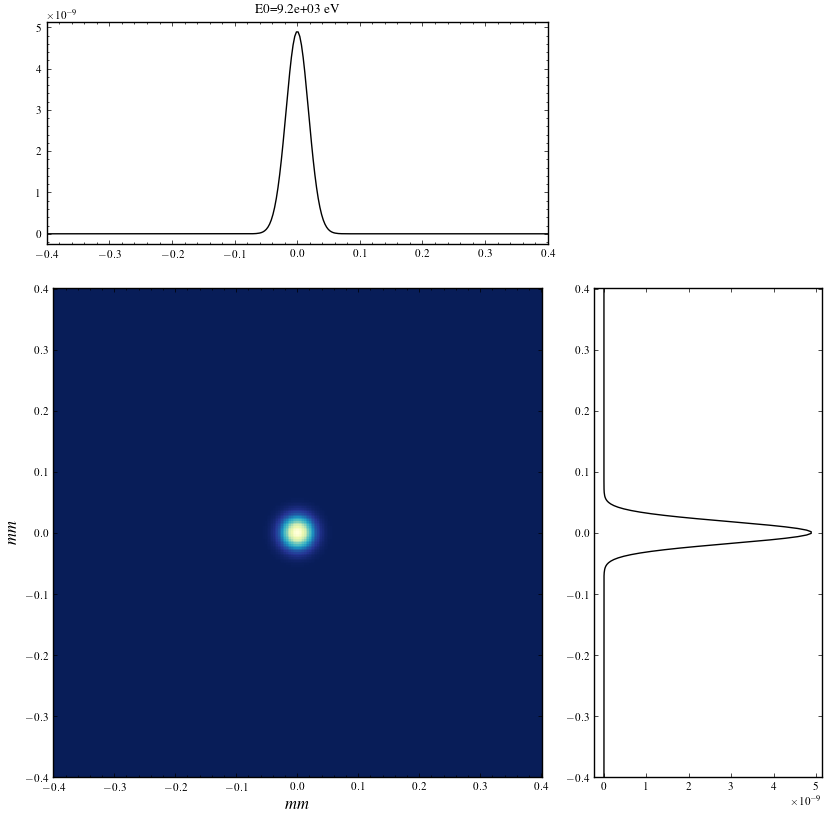

(array([1.19354307e-05, 1.19354307e-05]), 1.4145693283936398e-06)


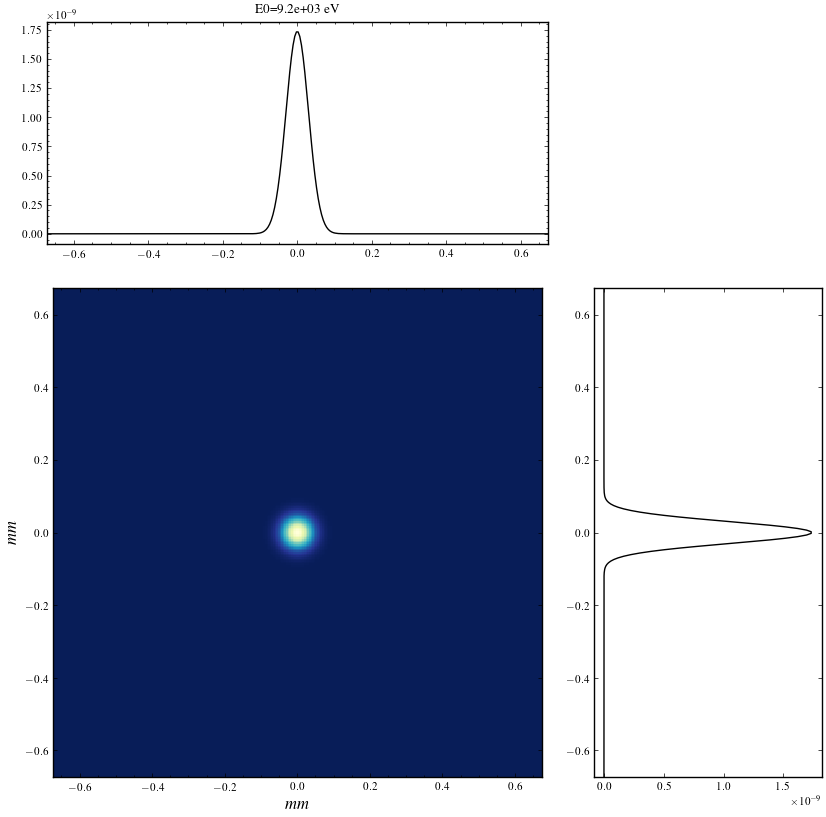

(array([2.00290756e-05, 2.00290756e-05]), 2.4106576692327046e-06)


In [251]:
wfr = wavefront_from_array(cfr, cfr.shape[0], cfr.shape[1], cfr.shape[2],
                           dx = 2.67e-06, dy = 2.67e-06, dz = sampling_interval_t,
                           ekev = 9.2)

from wpg.wpg_uti_wf import plot_intensity_map, get_intensity_on_axis
from wpg import srwlib
ii = wfr.get_intensity()
ii =ii.sum(0).sum(0)
srwlib.srwl.SetRepresElecField(wfr._srwl_wf, 'f')
plot_intensity_map(wfr)

print(wfr.get_beam_size())

bl = Beamline()
bl.append(Drift(1), propagation_parameters(1,1,1,1, mode = 'fresnel'))
bl.propagate(wfr)
plot_intensity_map(wfr)
print(wfr.get_beam_size())

bl = Beamline()
bl.append(Drift(1), propagation_parameters(1,1,1,1, mode = 'quadratic'))
bl.propagate(wfr)
plot_intensity_map(wfr)
print(wfr.get_beam_size())
